In [45]:
import pandas as pd
import numpy as np

import re
import nltk
import html
import string


from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, roc_auc_score, ConfusionMatrixDisplay

from transformers import pipeline
from transformers import BertTokenizer, BertModel
from transformers import XLNetTokenizer, XLNetModel
import torch
import gensim

from tqdm import tqdm
import optuna

from catboost import CatBoostClassifier
import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

import spacy
from nltk.corpus import stopwords
from nltk import PorterStemmer, WordNetLemmatizer

from gensim.models import Word2Vec
from imblearn.over_sampling import RandomOverSampler, ADASYN


import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import warnings

warnings.filterwarnings("ignore", category=FutureWarning)
plt.style.use('ggplot')

In [2]:
%matplotlib inline

In [4]:
df = pd.read_csv("/kaggle/input/kuc-hackathon-winter-2018/drugsComTrain_raw.csv")
test = pd.read_csv('/kaggle/input/kuc-hackathon-winter-2018/drugsComTest_raw.csv')


In [5]:
def classes_def(x):
    if x <= 4:
        return 0
    elif x >= 7:
        return 2
    else:
        return 1
    

df['label']=df['rating'].apply(lambda x:classes_def(x))
test['label']=test['rating'].apply(lambda x:classes_def(x))


In [6]:
test.label.value_counts() / test.label.count()

label
2    0.659153
0    0.251032
1    0.089815
Name: count, dtype: float64

In [7]:
y_train = df.label
y_test = test.label

# EDA

In [27]:
df

,uniqueID,drugName,condition,review,rating,date,usefulCount,label
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27,2
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,2
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17,1
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10,2
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37,2
...,...,...,...,...,...,...,...,...
161292,191035,Campral,Alcohol Dependence,"""I wrote my first report in Mid-October of 201...",10,31-May-15,125,2
161293,127085,Metoclopramide,Nausea/Vomiting,"""I was given this in IV before surgey. I immed...",1,1-Nov-11,34,0
161294,187382,Orencia,Rheumatoid Arthritis,"""Limited improvement after 4 months, developed...",2,15-Mar-14,35,0
161295,47128,Thyroid desiccated,Underactive Thyroid,"""I&#039;ve been on thyroid medication 49 years...",10,19-Sep-15,79,2


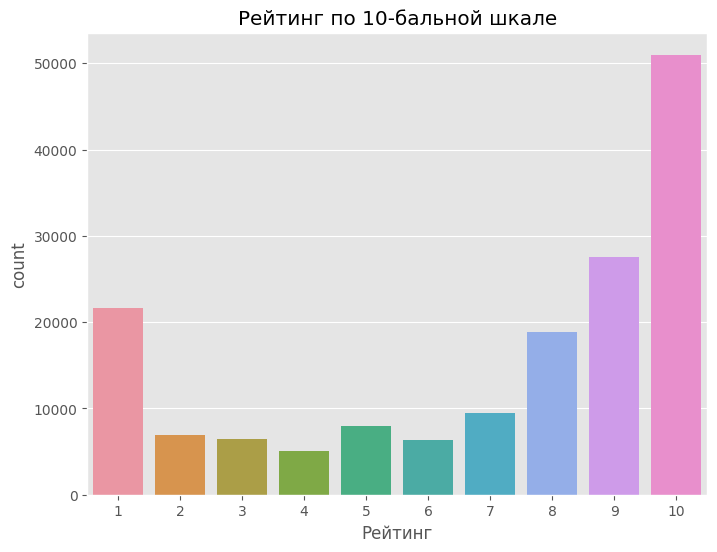

In [8]:
plt.figure(figsize=(8,6))
sns.countplot(data=df, x="rating");
plt.xlabel('Рейтинг')
plt.title('Рейтинг по 10-бальной шкале');

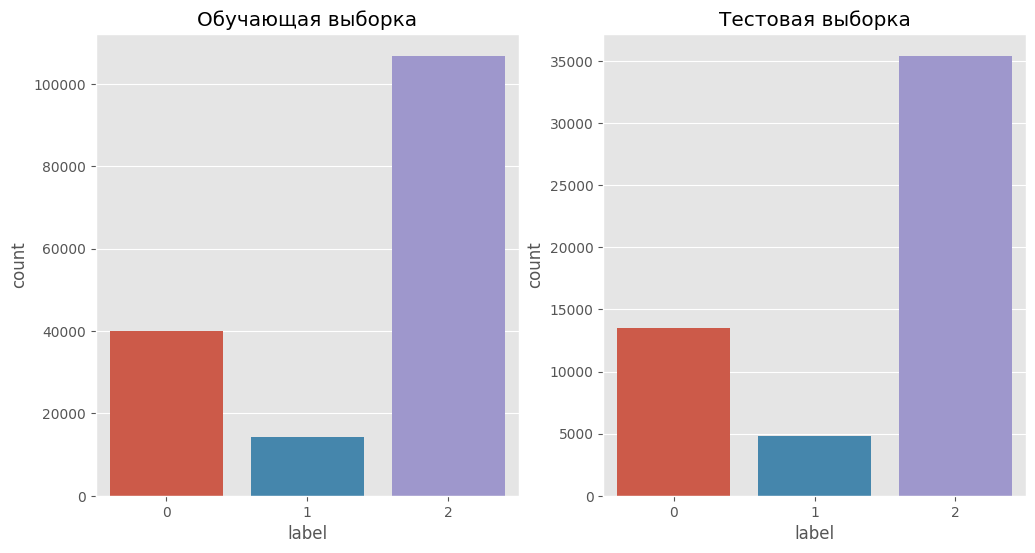

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(12,6))

sns.countplot(data=df, x="label", ax=axs[0]);
axs[0].set_title('Обучающая выборка')

sns.countplot(data=test, x="label", ax=axs[1]);
axs[1].set_title('Тестовая выборка')

plt.show()

In [13]:
df.describe()

,uniqueID,rating,usefulCount,label
count,161297.000000,161297.000000,161297.000000,161297.000000
mean,115923.585305,6.994377,28.004755,1.414087
std,67004.445170,3.272329,36.403742,0.859961
min,2.000000,1.000000,0.000000,0.000000
25%,58063.000000,5.000000,6.000000,1.000000
50%,115744.000000,8.000000,16.000000,2.000000
75%,173776.000000,10.000000,36.000000,2.000000
max,232291.000000,10.000000,1291.000000,2.000000


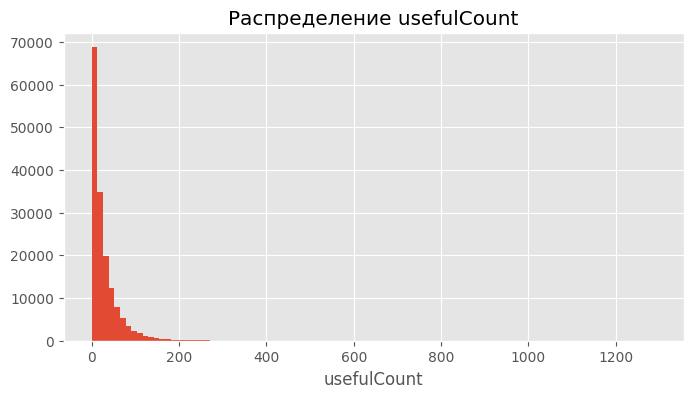

In [14]:
plt.figure(figsize=(8,4))

df.usefulCount.hist(bins=100)
plt.xlabel('usefulCount')
plt.title('Распределение usefulCount');

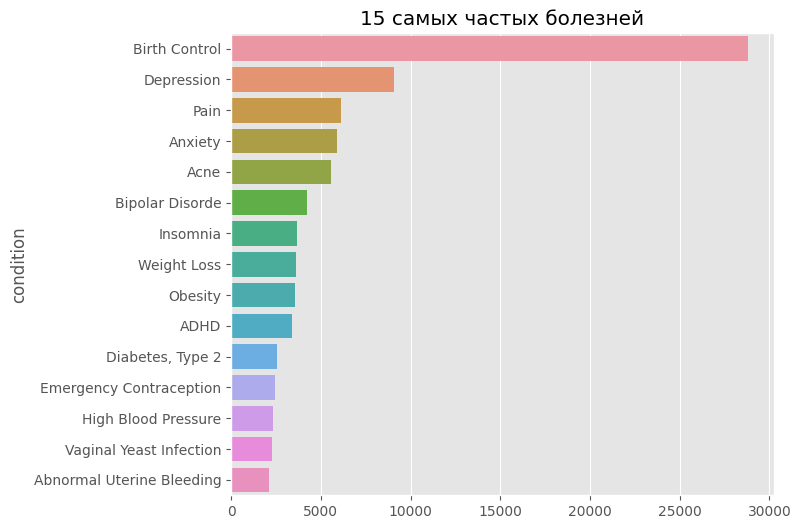

In [15]:
plt.figure(figsize=(7,6))
cond = df.condition.value_counts()[:15]
sns.barplot(y=cond.index, x=cond.values)
plt.title('15 самых частых болезней');

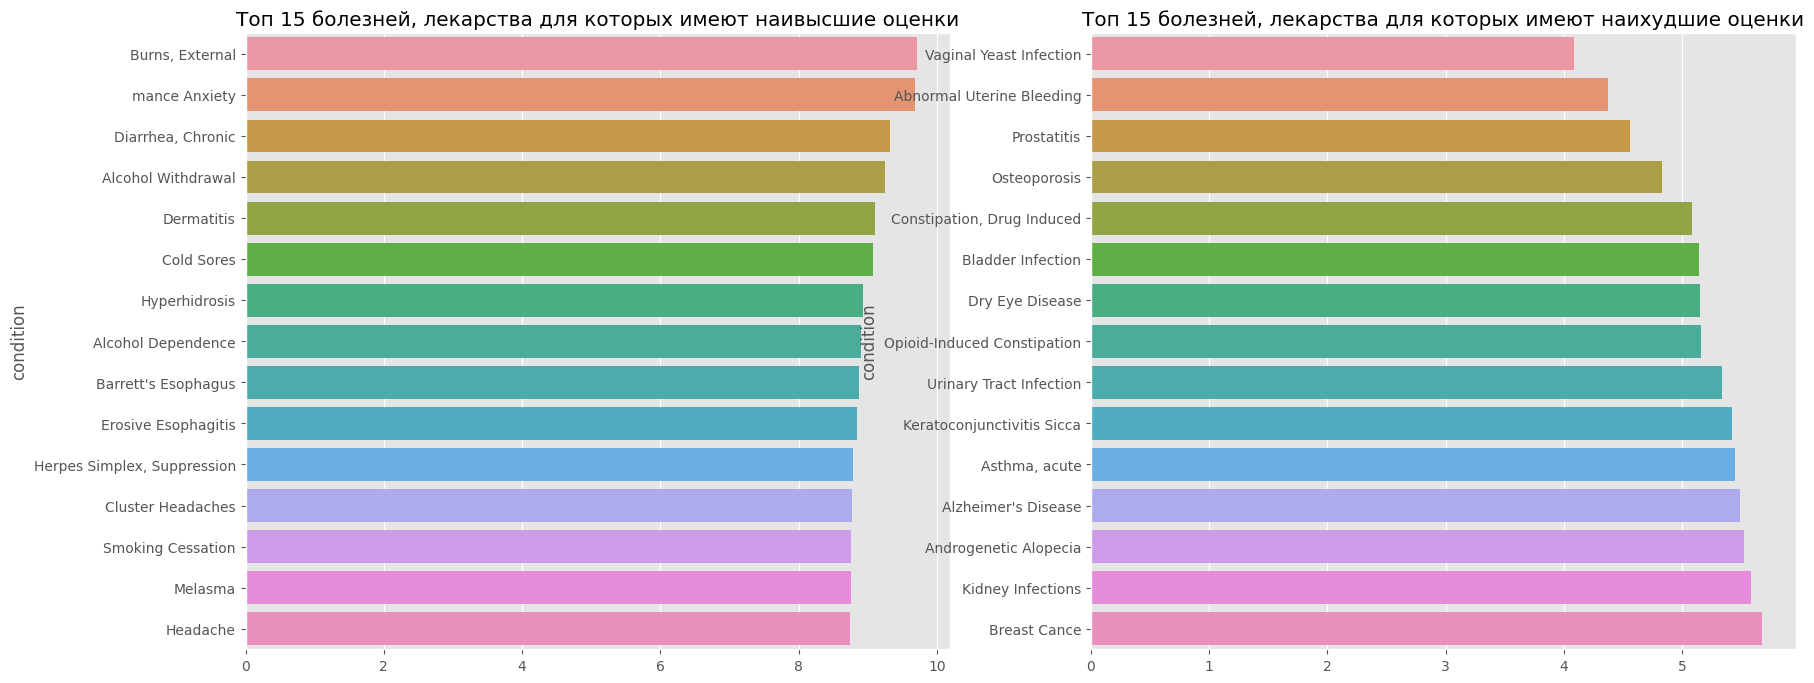

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(20,8))


popular_conditions = df['condition'].value_counts()[df['condition'].value_counts() > 40].index.tolist()
condintion_best_rate = df[df['condition'].isin(popular_conditions)].groupby('condition')['rating'].mean().sort_values(ascending=False)[:15]
sns.barplot(y=condintion_best_rate.index, x=condintion_best_rate.values, ax=axs[0])
axs[0].set_title('Топ 15 болезней, лекарства для которых имеют наивысшие оценки')

condintion_best_rate = df[df['condition'].isin(popular_conditions)].groupby('condition')['rating'].mean().sort_values(ascending=True)[:15]
sns.barplot(y=condintion_best_rate.index, x=condintion_best_rate.values, ax=axs[1])
axs[1].set_title('Топ 15 болезней, лекарства для которых имеют наихудшие оценки');


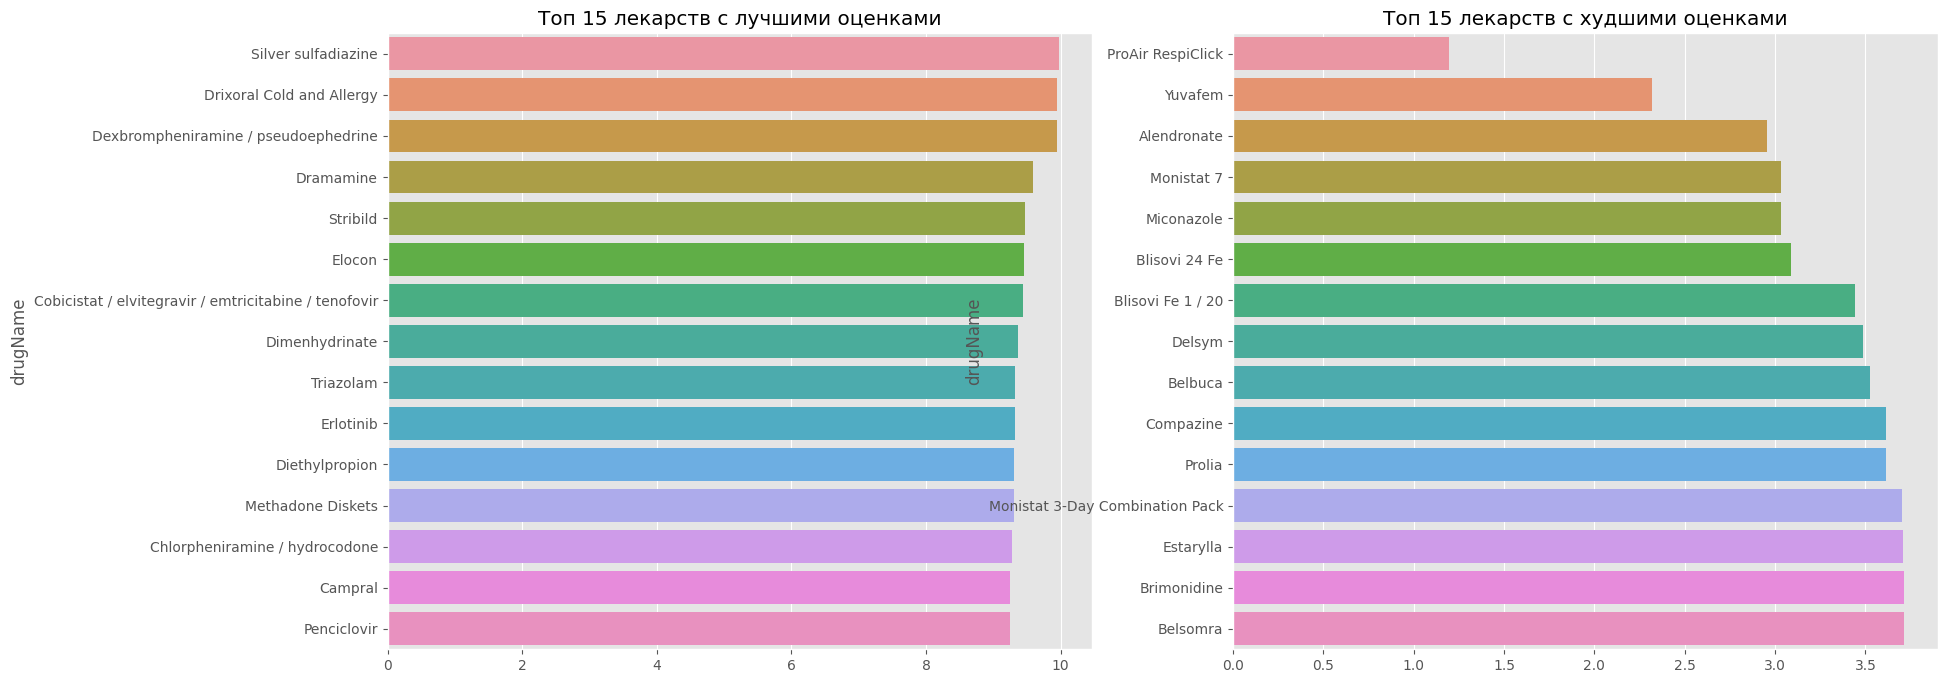

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(20,8))

popular_conditions = df['drugName'].value_counts()[df['drugName'].value_counts() > 20].index.tolist()
condintion_best_rate = df[df['drugName'].isin(popular_conditions)].groupby('drugName')['rating'].mean().sort_values(ascending=False)[:15]
sns.barplot(y=condintion_best_rate.index, x=condintion_best_rate.values, ax=axs[0])
axs[0].set_title('Топ 15 лекарств с лучшими оценками')

condintion_best_rate = df[df['drugName'].isin(popular_conditions)].groupby('drugName')['rating'].mean().sort_values(ascending=True)[:15]
sns.barplot(y=condintion_best_rate.index, x=condintion_best_rate.values, ax=axs[1])
axs[1].set_title('Топ 15 лекарств с худшими оценками');


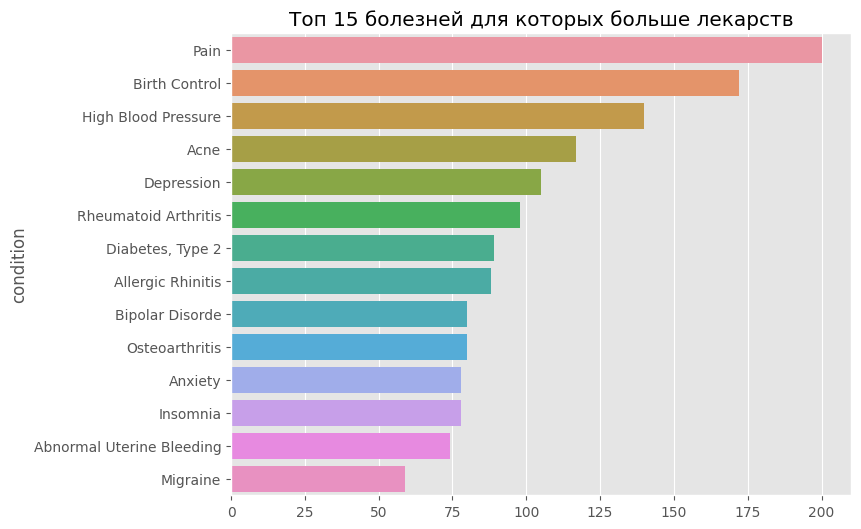

In [18]:
plt.figure(figsize=(8,6))

num_drug_for_cond = df.groupby('condition')['drugName'].nunique().sort_values(ascending=False)[1:15]

sns.barplot(y=num_drug_for_cond.index, x=num_drug_for_cond.values)
plt.title('Топ 15 болезней для которых больше лекарств');

Text(0.5, 1.0, 'Распределение среднего рейтинга лекарств')

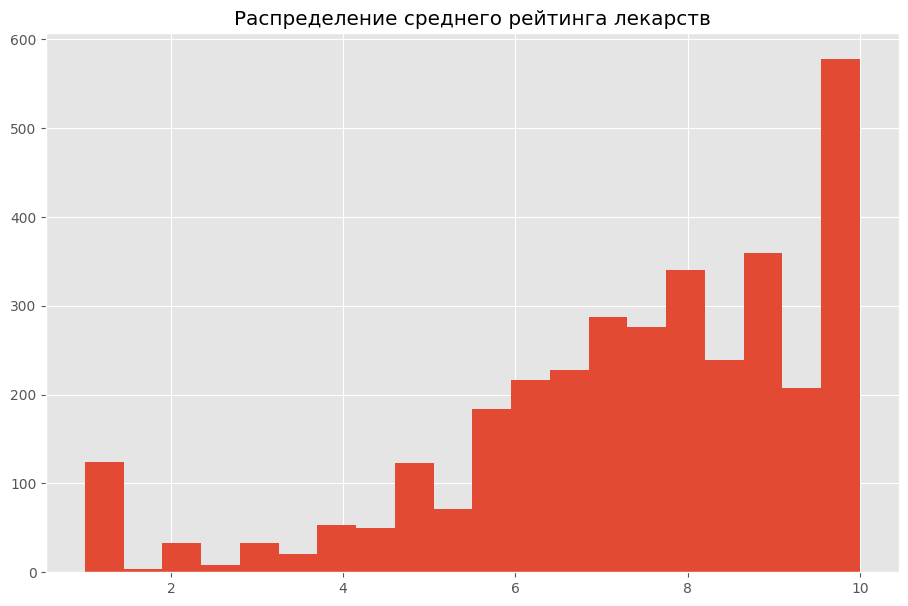

In [19]:
plt.figure(figsize=(11,7))
df.groupby('drugName').rating.mean().hist(bins=20)
plt.title('Распределение среднего рейтинга лекарств')

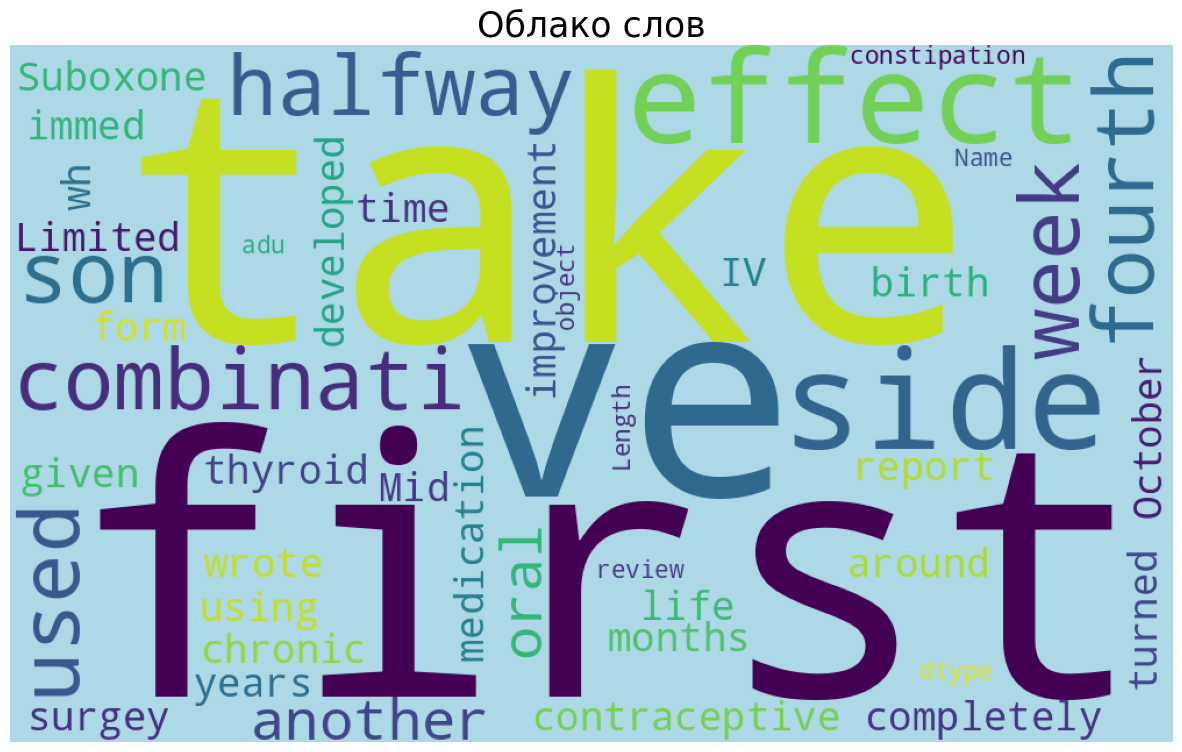

In [20]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS

stopwords = set(STOPWORDS)

wordcloud = WordCloud(background_color='lightblue', stopwords=stopwords, width = 1000, height = 600).generate(str(df['review']))

plt.rcParams['figure.figsize'] = (15, 15)
plt.title('Облако слов', fontsize = 25)
print(wordcloud)
plt.axis('off')
plt.imshow(wordcloud)
plt.show();


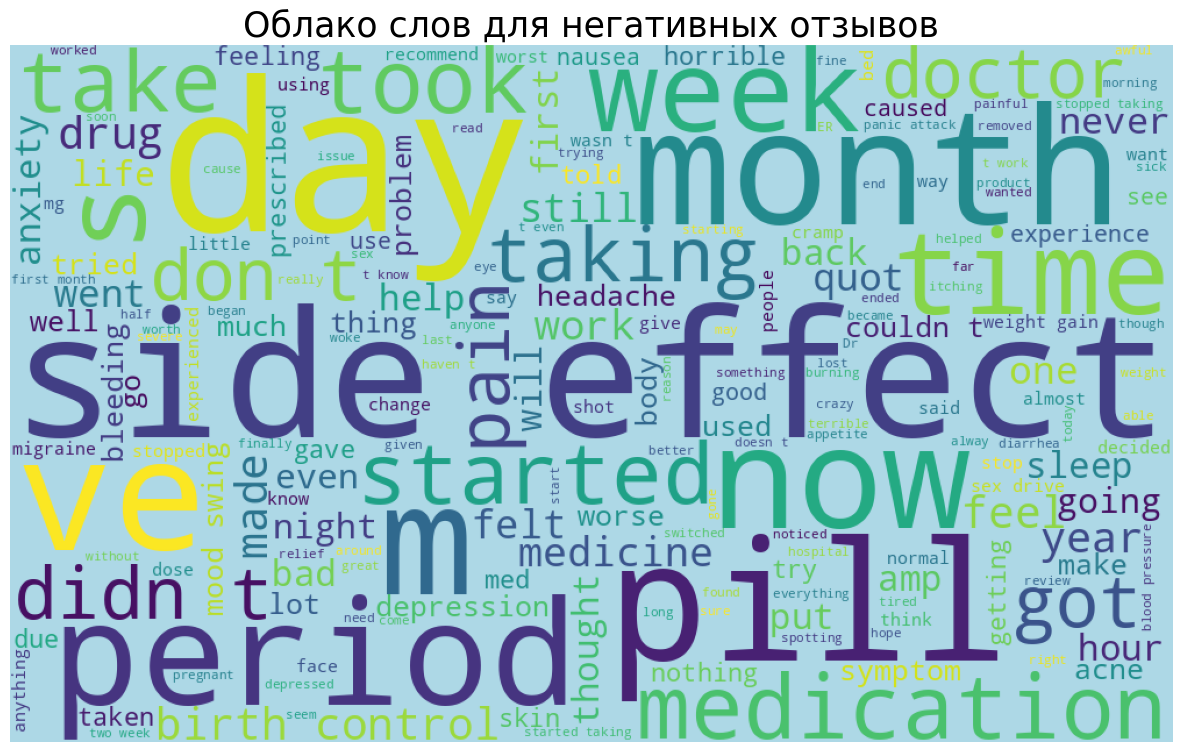

In [23]:
neg_sentiments = " ".join([text for text in df['review'][df['label'] == 0]])

from wordcloud import WordCloud
from wordcloud import STOPWORDS

stopwords = set(STOPWORDS)
wordcloud = WordCloud(background_color = 'lightblue', stopwords=stopwords, width = 1000, height=600).generate(neg_sentiments)

plt.rcParams['figure.figsize'] = (15, 15)
plt.title('Облако слов для негативных отзывов', fontsize = 25)
print(wordcloud)
plt.axis('off')
plt.imshow(wordcloud)
plt.show();


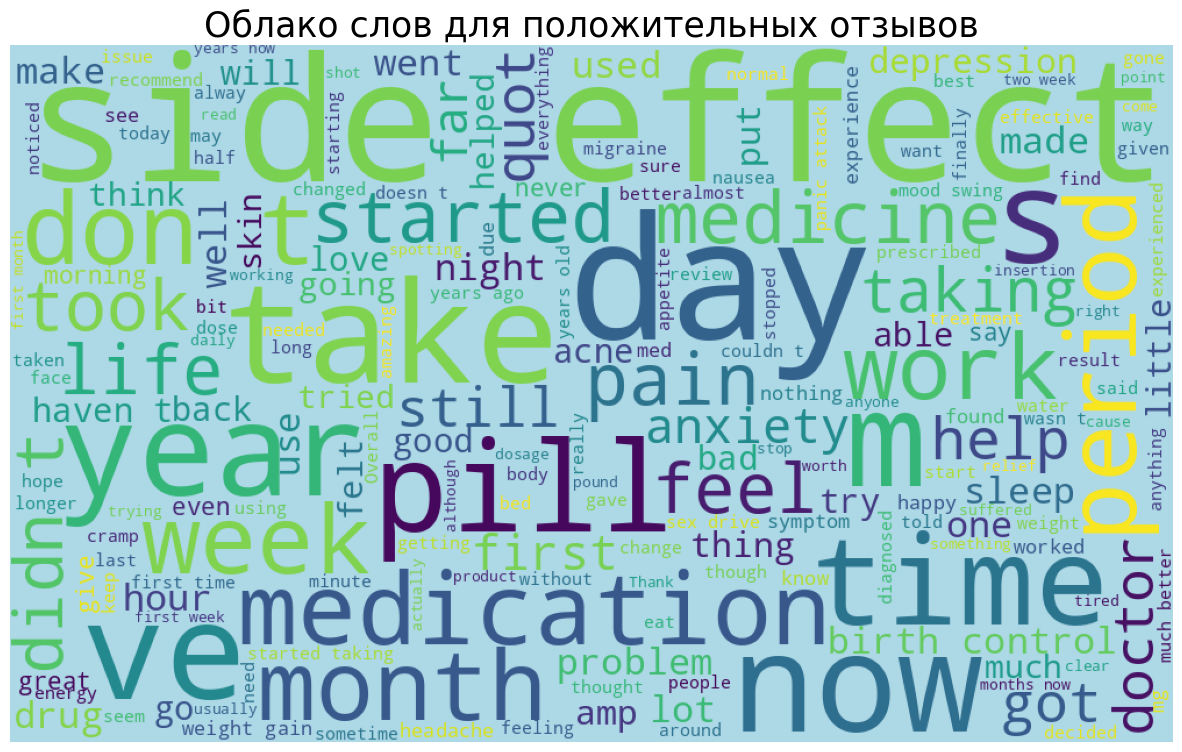

In [25]:
positive_sentiments = " ".join([text for text in df['review'][df['label'] == 2]])

from wordcloud import WordCloud
from wordcloud import STOPWORDS

stopwords = set(STOPWORDS)
wordcloud = WordCloud(background_color = 'lightblue', stopwords=stopwords, width = 1000, height=600).generate(positive_sentiments)

plt.rcParams['figure.figsize'] = (15, 15)
plt.title('Облако слов для положительных отзывов', fontsize = 25)
print(wordcloud)
plt.axis('off')
plt.imshow(wordcloud)
plt.show();

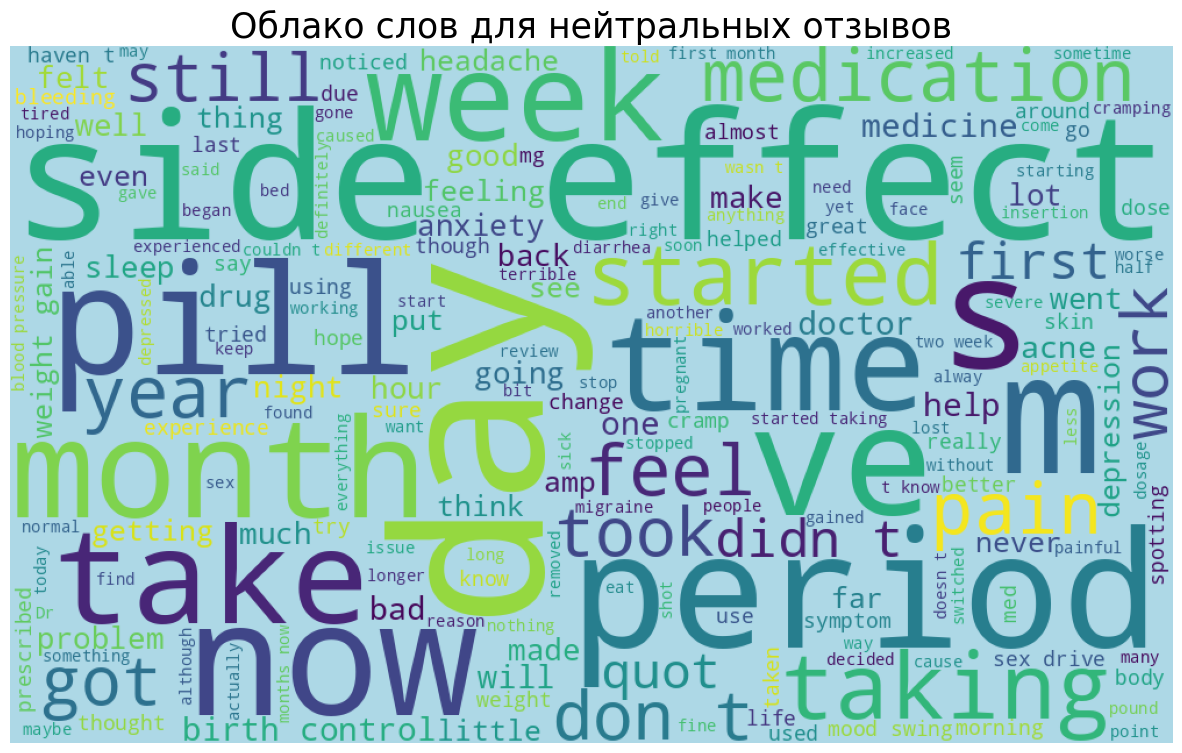

In [24]:
neut_sentiments = " ".join([text for text in df['review'][df['label'] == 1]])

from wordcloud import WordCloud
from wordcloud import STOPWORDS

stopwords = set(STOPWORDS)
wordcloud = WordCloud(background_color = 'lightblue', stopwords=stopwords, width = 1000, height=600).generate(neut_sentiments)

plt.rcParams['figure.figsize'] = (15, 15)
plt.title('Облако слов для нейтральных отзывов', fontsize = 25)
print(wordcloud)
plt.axis('off')
plt.imshow(wordcloud)
plt.show()


In [28]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/


Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [33]:
stop_words = stopwords.words('english')


In [34]:
PUNCT_TO_REMOVE = string.punctuation

def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

from nltk.stem.porter import PorterStemmer


def stem_words(text):
    stemmer = PorterStemmer()
    return " ".join([stemmer.stem(word) for word in text.split()])

from nltk.stem import WordNetLemmatizer


from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])


def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)
def remove_html(text):
    text = html.unescape(text)
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)


In [35]:
def prep(text):
    text = text.str.lower()
    text = text.apply(remove_emoji)
    text = text.apply(remove_urls)
    text = text.apply(remove_html)

    text = text.apply(lambda t: remove_punctuation(t))
    text = text.apply(lambda t: lemmatize_words(t))
    text = text.apply(lambda t: remove_stopwords(t))

    return text


In [36]:
X_test = prep(test['review'])


In [37]:
X_train = prep(df['review'])


In [38]:

def evaluate_model(model, X_test_data, y_test):
    
        metrics = {'f1_micro': [],'f1_weighted': [],'f1_macro': []}
        
        
        pred = model.predict(X_test_data)
        f1_micro = f1_score(y_test, pred, average='micro')
        f1_weighted = f1_score(y_test, pred, average='weighted')
        f1_macro = f1_score(y_test, pred, average='macro')

        
        metrics['f1_micro'].append(f1_micro)
        metrics['f1_weighted'].append(f1_weighted)
        metrics['f1_macro'].append(f1_macro)
        print(classification_report(y_test, pred))

        
        return metrics

# tf idf

In [ ]:
cb = CatBoostClassifier(task_type="GPU", verbose=500, random_state=10)


vectr = TfidfVectorizer(max_df=0.8, min_df=10, analyzer='word')

def pipe(m, vect=vectr):
    pipeline = Pipeline(steps=[

        ('vector', vect),
        ('clf', m)
    ])
    
    return pipeline

models = [pipe(m=cb).fit(X_train, y_train),
          pipe(m=LinearSVC()).fit(X_train, y_train),
          pipe(LogisticRegression(random_state=12)).fit(X_train, y_train)]

In [40]:
metrics_tf_idf = {}
for i, j in enumerate(models):
    print(j[1])
    metrics_tf_idf[str(j[1])] = evaluate_model(models[i], X_test, y_test)

              precision    recall  f1-score   support

           0       0.72      0.60      0.65     13497
           1       0.51      0.02      0.04      4829
           2       0.79      0.95      0.86     35440

    accuracy                           0.78     53766
   macro avg       0.67      0.52      0.52     53766
weighted avg       0.75      0.78      0.74     53766

LinearSVC()
              precision    recall  f1-score   support

           0       0.69      0.69      0.69     13497
           1       0.43      0.04      0.08      4829
           2       0.82      0.92      0.87     35440

    accuracy                           0.79     53766
   macro avg       0.65      0.55      0.55     53766
weighted avg       0.75      0.79      0.75     53766

LogisticRegression(random_state=12)
              precision    recall  f1-score   support

           0       0.70      0.66      0.68     13497
           1       0.37      0.05      0.08      4829
           2       0.82    

In [41]:
pd.DataFrame(metrics_tf_idf)

,<catboost.core.CatBoostClassifier object at 0x7b0a005a9e10>,LinearSVC(),LogisticRegression(random_state=12)
f1_micro,[0.7763270468325708],[0.7850314325038127],[0.783599300673288]
f1_weighted,[0.7363571347045539],[0.7529325217210184],[0.7514113465856136]
f1_macro,[0.5188161989153731],[0.5452209454243273],[0.544645855321007]


# word2vec

In [42]:
tokenized_train = X_train.apply(lambda x: x.split())

word2vec_model = Word2Vec(tokenized_train, min_count=5, sg=0, vector_size=200)

def word_averaging(model, words):
    feature_vector = []
    for word in words:
        if word in model.wv.key_to_index:
            feature_vector.append(model.wv[word])
    if len(feature_vector) > 0:
        averaged_vector = np.mean(feature_vector, axis=0)
    else:
        averaged_vector = np.zeros(model.vector_size)
    return averaged_vector

# Преобразуем текст в векторы с помощью word2vec
def word_vectorize(tokenized_data, model):
    word_vectors = tokenized_data.apply(lambda x: word_averaging(model, x))
    return pd.DataFrame(word_vectors.tolist())

X_train_w2v = word_vectorize(tokenized_data=X_train.apply(lambda x: x.split()), model=word2vec_model)
X_test_w2v = word_vectorize(tokenized_data=X_test.apply(lambda x: x.split()), model=word2vec_model)


In [43]:
X_train_w2v.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.553448,0.198884,-0.728074,0.311161,-0.654109,0.392565,0.108604,0.327801,-0.288311,-0.422656,...,-0.080452,-0.329230,-0.025186,-0.206063,-0.193715,-0.558701,0.099847,-0.404384,-0.379624,0.345064
1,0.544415,0.126512,0.104345,-0.528398,-0.600204,0.196448,0.115051,-0.502621,0.273817,-0.154590,...,-0.088438,-0.062228,-0.001034,0.403830,0.343393,-0.274341,-0.182204,0.094242,-0.020950,0.225785
2,0.637960,0.113762,0.009743,-0.178197,-0.361292,-0.209841,0.674337,-0.213036,0.749651,-0.075913,...,-0.113479,0.096638,0.123359,0.645686,0.349988,0.218906,-0.136358,0.305358,0.054079,0.753598
3,0.465672,0.035156,0.104497,-0.406221,-0.351258,-0.387144,0.636753,-0.634448,0.655108,0.183745,...,-0.072131,0.220458,0.059382,0.710356,0.601305,0.245795,0.019681,0.290998,-0.124924,0.723813
4,0.041750,-0.020263,0.173334,-0.049056,-0.074256,0.105688,-0.064909,0.206682,-0.009431,-0.165749,...,0.215442,0.098315,-0.567052,0.162663,0.236502,-0.100084,0.154742,0.122186,-0.238636,-0.188369


In [ ]:
cb = CatBoostClassifier(**{'depth': 8, 'iterations': 2000, 'min_data_in_leaf': 5, 'auto_class_weights': 'SqrtBalanced', 'l2_leaf_reg': 0.005617909277967069}, verbose=500, task_type="GPU",random_state=10)
lgbm = lgb.LGBMClassifier(verbose=-1, device = "gpu", max_depth=8, class_weights='balanced', random_state=10)
lr = LogisticRegression(C=1, random_state=10)


models_wv = [cb.fit(X_train_w2v, y_train),
            lgbm.fit(X_train_w2v, y_train),
            lr.fit(X_train_w2v, y_train)]



In [47]:
metrics_w2v = {}
for i, j in enumerate(models_wv):
    print(j)
    metrics_w2v[str(j)+str(i)] = evaluate_model(models_wv[i], X_test_w2v, y_test)


              precision    recall  f1-score   support

           0       0.73      0.74      0.73     13497
           1       0.79      0.35      0.48      4829
           2       0.86      0.91      0.88     35440

    accuracy                           0.82     53766
   macro avg       0.79      0.67      0.70     53766
weighted avg       0.82      0.82      0.81     53766

LGBMClassifier(class_weights='balanced', device='gpu', max_depth=8,
               random_state=10, verbose=-1)
              precision    recall  f1-score   support

           0       0.69      0.56      0.62     13497
           1       0.66      0.01      0.01      4829
           2       0.78      0.94      0.85     35440

    accuracy                           0.76     53766
   macro avg       0.71      0.50      0.50     53766
weighted avg       0.75      0.76      0.72     53766

LogisticRegression(C=1, random_state=10)
              precision    recall  f1-score   support

           0       0.66      0

In [48]:
pd.DataFrame(metrics_w2v)

,<catboost.core.CatBoostClassifier object at 0x7b09809ae710>0,"LGBMClassifier(class_weights='balanced', device='gpu', max_depth=8,\n random_state=10, verbose=-1)1","LogisticRegression(C=1, random_state=10)2"
f1_micro,[0.8201465610236953],[0.7618569356098649],[0.7489305509057769]
f1_weighted,[0.8103628689165132],[0.718858268071644],[0.7070772025553714]
f1_macro,[0.6995588179879358],[0.4952938287456555],[0.48442207279089794]


# Подбор гиперпараметров

In [ ]:
def objective_cb(trial):
    param = {
        "depth": trial.suggest_int("depth", 6, 12),
        "iterations": trial.suggest_int("iterations", 1000, 3000, step=500 ),
        'min_data_in_leaf': trial.suggest_int("min_data_in_leaf", 1, 10),
        "auto_class_weights": trial.suggest_categorical("auto_class_weights", ["SqrtBalanced", "Balanced",]),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 20.0, log=True),
    }


    cb = CatBoostClassifier(**param, verbose=500, task_type="GPU", random_state=10)

    cb.fit(X_train_w2v, y_train)
    predictions = cb.predict(X_test_w2v)
    score_f = f1_score(y_test, predictions, average='weighted')

    return score_f

study_cb = optuna.create_study(direction="maximize", study_name="cb")
study_cb.optimize(objective_cb, n_trials=50)
print(study_cb.best_trial)

# TRANSFORMERS

In [ ]:

gpu_num = 0
device = torch.device(f'cuda:{gpu_num}' if torch.cuda.is_available() else 'cpu')
# model_name="bert-base-uncased",
# tokenizer = BertTokenizer.from_pretrained(model_name)
# model = BertModel.from_pretrained(model_name)

def get_emdeddings(model, tokenizer, max_length=256):
    
        
        tokenized_texts = X_train.apply(lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=max_length, truncation=True)).values
        max_len = max(len(text) for text in tokenized_texts)
        padded_texts = torch.tensor([text + [0] * (max_len - len(text)) for text in tokenized_texts])
        attention_mask = torch.where(padded_texts > 0, 1, 0)
        
        model.to(device)
        batch_size = 32
        
        features = []
        with torch.no_grad():
            for i in tqdm(range(0, len(padded_texts), batch_size)):
                texts_batch = padded_texts[i : i + batch_size].to(device)
                mask_batch = attention_mask[i : i + batch_size].to(device)
                output = model(texts_batch, mask_batch)
                batch_features = output.last_hidden_state[:, 0, :].cpu().numpy()
                features.append(batch_features)

        features = np.concatenate(features, axis=0)

        

        tokenized_texts_test = X_test.apply(lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=max_length, truncation=True)).values
        max_len_test = max(len(text) for text in tokenized_texts_test)
        padded_texts_test = torch.tensor([text + [0] * (max_len_test - len(text)) for text in tokenized_texts_test])
        attention_mask_test = torch.where(padded_texts_test > 0, 1, 0)

        features_test = []
        with torch.no_grad():
            for i in tqdm(range(0, len(padded_texts_test), batch_size)):
                texts_batch_test = padded_texts_test[i : i + batch_size].to(device)
                mask_batch_test = attention_mask_test[i : i + batch_size].to(device)
                output_test = model(texts_batch_test, mask_batch_test)
                batch_features_test = output_test.last_hidden_state[:, 0, :].cpu().numpy()
                features_test.append(batch_features_test)

        features_test = np.concatenate(features_test, axis=0)

        return features, features_test

# XLNET

In [ ]:

tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')
model = XLNetModel.from_pretrained('xlnet-base-cased')
X_xlnet_train, X_xlnet_test = get_emdeddings(model=model, tokenizer=tokenizer, max_length=256)

In [ ]:
np.save('train_embeddings_xlnet.npy', X_xlnet_train)
np.save('test_embeddings_xlnet.npy', X_xlnet_test)


In [7]:
X_xlnet_train = np.load('/kaggle/input/embedd/train_embeddings_xlnet.npy')
X_xlnet_test = np.load('/kaggle/input/embedd/test_embeddings_xlnet.npy')

In [15]:
cb_xl = CatBoostClassifier(verbose=300, task_type='GPU', auto_class_weights='Balanced', iterations=2000, max_depth=10, random_state=12)
cb_xl.fit(X_xlnet_train, y_train)
predictions = cb_xl.predict(X_xlnet_test)


Learning rate set to 0.102774
0:	learn: 1.0915476	total: 318ms	remaining: 10m 35s
300:	learn: 0.4613660	total: 50.3s	remaining: 4m 44s
600:	learn: 0.2618078	total: 1m 38s	remaining: 3m 49s
900:	learn: 0.1688842	total: 2m 25s	remaining: 2m 57s
1200:	learn: 0.1184743	total: 3m 10s	remaining: 2m 6s
1500:	learn: 0.0912831	total: 3m 52s	remaining: 1m 17s
1800:	learn: 0.0755682	total: 4m 30s	remaining: 29.9s
1999:	learn: 0.0682333	total: 4m 54s	remaining: 0us


In [16]:
confusion_matrix(y_test, predictions)
cb_xl_score = evaluate_model(cb_xl, X_xlnet_test, y_test)
cb_xl_score

              precision    recall  f1-score   support

           0       0.85      0.76      0.80     13497
           1       0.99      0.60      0.75      4829
           2       0.88      0.96      0.92     35440

    accuracy                           0.88     53766
   macro avg       0.90      0.77      0.82     53766
weighted avg       0.88      0.88      0.87     53766



{'f1_micro': [0.8763902838224901],
 'f1_weighted': [0.8719255626031078],
 'f1_macro': [0.8212368121261395]}

In [17]:
confusion_matrix(y_test, predictions)

array([[10246,    24,  3227],
       [  398,  2904,  1527],
       [ 1451,    19, 33970]])

# CLINICAL BERT

In [18]:
train_embeddings_clinical = np.load("/kaggle/input/embedd/train_embeddings_clinical.npy")
test_embeddings_clinical = np.load('/kaggle/input/embedd/test_embeddings_clinical.npy')

In [19]:
cb_clin = CatBoostClassifier(verbose=300, task_type='GPU', auto_class_weights='Balanced', iterations=3000, max_depth=9, random_state=12)
cb_clin.fit(train_embeddings_clinical, y_train)
predictions = cb_clin.predict(test_embeddings_clinical)


Learning rate set to 0.073316
0:	learn: 1.0931422	total: 199ms	remaining: 9m 56s
300:	learn: 0.6900435	total: 29.3s	remaining: 4m 22s
600:	learn: 0.5024474	total: 57.7s	remaining: 3m 50s
900:	learn: 0.3816010	total: 1m 25s	remaining: 3m 19s
1200:	learn: 0.2987623	total: 1m 53s	remaining: 2m 49s
1500:	learn: 0.2392106	total: 2m 20s	remaining: 2m 20s
1800:	learn: 0.1962502	total: 2m 47s	remaining: 1m 51s
2100:	learn: 0.1642127	total: 3m 14s	remaining: 1m 23s
2400:	learn: 0.1397239	total: 3m 40s	remaining: 55s
2700:	learn: 0.1217268	total: 4m 5s	remaining: 27.2s
2999:	learn: 0.1080639	total: 4m 29s	remaining: 0us


In [20]:
confusion_matrix(y_test, predictions)

array([[10746,    45,  2706],
       [  577,  2917,  1335],
       [ 1798,    53, 33589]])

In [21]:
cb_clin_score = evaluate_model(cb_clin, test_embeddings_clinical, y_test)
cb_clin_score

              precision    recall  f1-score   support

           0       0.82      0.80      0.81     13497
           1       0.97      0.60      0.74      4829
           2       0.89      0.95      0.92     35440

    accuracy                           0.88     53766
   macro avg       0.89      0.78      0.82     53766
weighted avg       0.88      0.88      0.88     53766



{'f1_micro': [0.8788453669605327],
 'f1_weighted': [0.8754914834840963],
 'f1_macro': [0.8235139091991464]}

# ROBERTA

In [22]:
train_embeddings_roberta = np.load("/kaggle/input/embedd/train_embeddings_roberta.npy")
test_embeddings_roberta = np.load('/kaggle/input/embedd/test_embeddings_roberta.npy')

In [23]:
cb_roberta = CatBoostClassifier(verbose=300, task_type='GPU', auto_class_weights='Balanced', iterations=3000, max_depth=10, random_state=12)
cb_roberta.fit(train_embeddings_roberta, y_train)
predictions = cb_roberta.predict(test_embeddings_roberta)
confusion_matrix(y_test, predictions)

Learning rate set to 0.073316
0:	learn: 1.0851675	total: 283ms	remaining: 14m 8s
300:	learn: 0.5500076	total: 48.4s	remaining: 7m 13s
600:	learn: 0.3542586	total: 1m 34s	remaining: 6m 18s
900:	learn: 0.2435555	total: 2m 21s	remaining: 5m 28s
1200:	learn: 0.1802925	total: 3m 5s	remaining: 4m 37s
1500:	learn: 0.1413497	total: 3m 46s	remaining: 3m 46s
1800:	learn: 0.1164453	total: 4m 26s	remaining: 2m 57s
2100:	learn: 0.0993649	total: 5m 3s	remaining: 2m 9s
2400:	learn: 0.0875903	total: 5m 38s	remaining: 1m 24s
2700:	learn: 0.0790170	total: 6m 12s	remaining: 41.2s
2999:	learn: 0.0727974	total: 6m 44s	remaining: 0us


array([[11158,    35,  2304],
       [  659,  2928,  1242],
       [ 1795,    43, 33602]])

In [24]:
cb_roberta_score = evaluate_model(cb_roberta, test_embeddings_roberta, y_test)
cb_roberta_score

              precision    recall  f1-score   support

           0       0.82      0.83      0.82     13497
           1       0.97      0.61      0.75      4829
           2       0.90      0.95      0.93     35440

    accuracy                           0.89     53766
   macro avg       0.90      0.79      0.83     53766
weighted avg       0.89      0.89      0.88     53766



{'f1_micro': [0.8869545809619462],
 'f1_weighted': [0.8840396974232665],
 'f1_macro': [0.8321462176258185]}

## ADASYN + ROBERTA

In [ ]:
adasyn = ADASYN(random_state=12)
train_embeddings_roberta_adasyn, y_train_adasyn = adasyn.fit_resample(train_embeddings_roberta, y_train)


In [41]:
cb_roberta = CatBoostClassifier(verbose=300, task_type='GPU', auto_class_weights='SqrtBalanced', iterations=10500, max_depth=10, random_state=12, learning_rate=0.025)
cb_roberta.fit(train_embeddings_roberta, y_train)
predictions = cb_roberta.predict(test_embeddings_roberta)
confusion_matrix(y_test, predictions)

0:	learn: 1.0892255	total: 268ms	remaining: 46m 53s
300:	learn: 0.7421875	total: 50s	remaining: 28m 13s
600:	learn: 0.6268757	total: 1m 37s	remaining: 26m 40s
900:	learn: 0.5422496	total: 2m 23s	remaining: 25m 31s
1200:	learn: 0.4742041	total: 3m 9s	remaining: 24m 29s
1500:	learn: 0.4170569	total: 3m 55s	remaining: 23m 33s
1800:	learn: 0.3680775	total: 4m 42s	remaining: 22m 42s
2100:	learn: 0.3282925	total: 5m 27s	remaining: 21m 48s
2400:	learn: 0.2928466	total: 6m 13s	remaining: 20m 59s
2700:	learn: 0.2631680	total: 6m 58s	remaining: 20m 8s
3000:	learn: 0.2375376	total: 7m 43s	remaining: 19m 19s
3300:	learn: 0.2154224	total: 8m 28s	remaining: 18m 29s
3600:	learn: 0.1957099	total: 9m 13s	remaining: 17m 40s
3900:	learn: 0.1789889	total: 9m 57s	remaining: 16m 50s
4200:	learn: 0.1645110	total: 10m 41s	remaining: 16m 1s
4500:	learn: 0.1517805	total: 11m 24s	remaining: 15m 11s
4800:	learn: 0.1401299	total: 12m 7s	remaining: 14m 23s
5100:	learn: 0.1300046	total: 12m 50s	remaining: 13m 35s
54

array([[10920,     9,  2568],
       [  559,  2900,  1370],
       [ 1277,     3, 34160]])

In [42]:
cb_roberta_score = evaluate_model(cb_roberta, test_embeddings_roberta, y_test)
cb_roberta_score

              precision    recall  f1-score   support

           0       0.86      0.81      0.83     13497
           1       1.00      0.60      0.75      4829
           2       0.90      0.96      0.93     35440

    accuracy                           0.89     53766
   macro avg       0.92      0.79      0.84     53766
weighted avg       0.90      0.89      0.89     53766



{'f1_micro': [0.8923855224491314],
 'f1_weighted': [0.8885110480158545],
 'f1_macro': [0.8367352049279811]}

In [43]:
confusion_matrix(y_test, predictions)

array([[10920,     9,  2568],
       [  559,  2900,  1370],
       [ 1277,     3, 34160]])

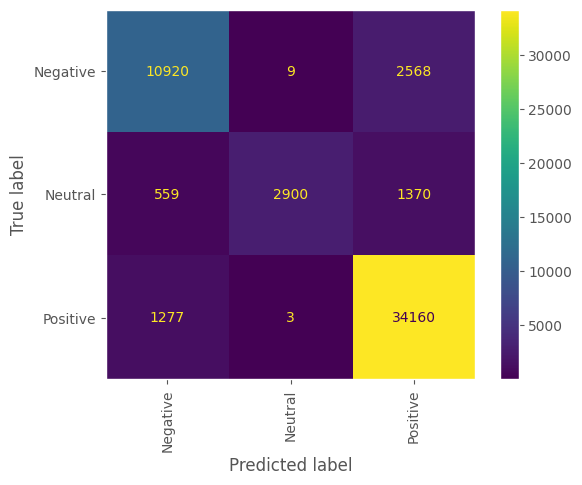

In [52]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, predictions), display_labels = ['Negative', 'Neutral', 'Positive'])
cm_display.plot(values_format = '.0f', ax=plt.gca(), xticks_rotation='vertical')

# Отображение графика без сетки
plt.grid(False)
plt.show()
